In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple
     |████████████████████████████████| 2.0 MB 3.3 MB/s eta 0:00:01
You should consider upgrading via the '/home/beth/anaconda3/bin/python -m pip install --upgrade pip' command.


In [9]:
!pip3 install catboost

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple
     |████████████████████████████████| 67.3 MB 9.4 MB/s eta 0:00:013
You should consider upgrading via the '/home/beth/anaconda3/bin/python -m pip install --upgrade pip' command.


In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

import lightgbm as lgb
import catboost as ctb
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve
from sklearn.metrics import classification_report

import graphviz
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [11]:
!pwd

/home/beth/simple_steps/Kaggle Study Group /project_1


In [12]:
train = pd.read_csv('/home/beth/simple_steps/Kaggle Study Group /project_1/tabular-playground-series-apr-2021/train.csv')
test = pd.read_csv('/home/beth/simple_steps/Kaggle Study Group /project_1/tabular-playground-series-apr-2021/train.csv')
sample_submission = pd.read_csv('/home/beth/simple_steps/Kaggle Study Group /project_1/tabular-playground-series-apr-2021/sample_submission.csv')

In [13]:
import pandas_profiling
train.profile_report()

In [14]:
data = pd.concat([train, test], sort = False)

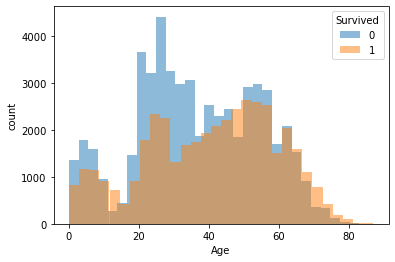

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.hist(train.loc[train['Survived'] ==0, 'Age'].dropna(), bins=30, alpha = 0.5, label='0')
plt.hist(train.loc[train['Survived'] ==1, 'Age'].dropna(), bins=30, alpha = 0.5, label='1')
plt.xlabel('Age')
plt.ylabel('count')
plt.legend(title='Survived')

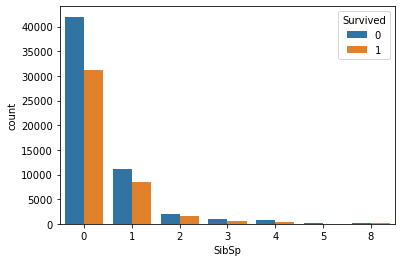

In [16]:
sns.countplot(x='SibSp', hue='Survived', data = train)
plt.legend(loc='upper right', title='Survived')

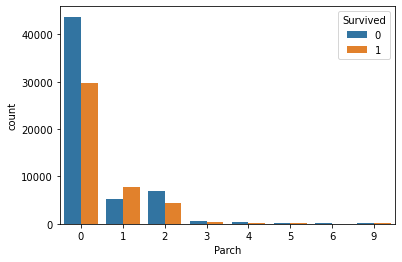

In [17]:
sns.countplot(x='Parch', hue='Survived', data = train)
plt.legend(loc='upper right', title='Survived')

(-5.0, 250.0)

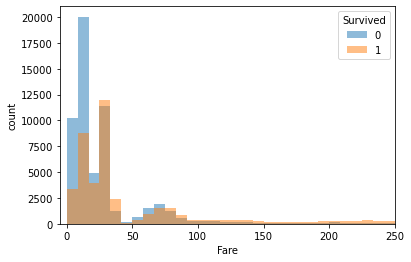

In [18]:
# The higher the fare, the higher the survival rate.
plt.hist(train.loc[train['Survived'] ==0, 'Fare'].dropna(), range=(0, 250), bins=30, alpha = 0.5, label='0')
plt.hist(train.loc[train['Survived'] ==1, 'Fare'].dropna(), range=(0, 250), bins=30, alpha = 0.5, label='1')
plt.xlabel('Fare')
plt.ylabel('count')
plt.legend(title='Survived')
plt.xlim(-5, 250)

<AxesSubplot:xlabel='Pclass', ylabel='count'>

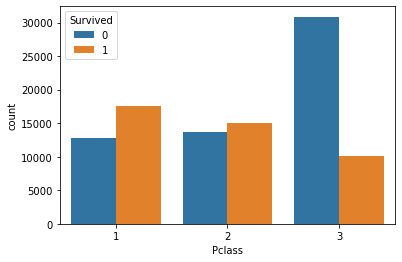

In [19]:
sns.countplot(x='Pclass', hue='Survived', data = train)

<AxesSubplot:xlabel='Sex', ylabel='count'>

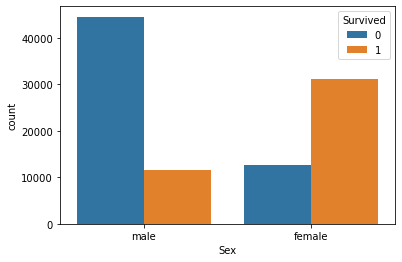

In [20]:
sns.countplot(x='Sex', hue='Survived', data = train)

<AxesSubplot:xlabel='Embarked', ylabel='count'>

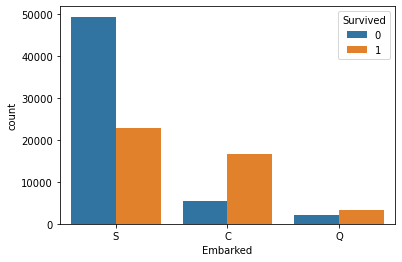

In [21]:
sns.countplot(x='Embarked', hue='Survived', data = train)

In [22]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  200000 non-null  int64  
 1   Survived     200000 non-null  int64  
 2   Pclass       200000 non-null  int64  
 3   Name         200000 non-null  object 
 4   Sex          200000 non-null  object 
 5   Age          193416 non-null  float64
 6   SibSp        200000 non-null  int64  
 7   Parch        200000 non-null  int64  
 8   Ticket       190754 non-null  object 
 9   Fare         199732 non-null  float64
 10  Cabin        64268 non-null   object 
 11  Embarked     199500 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 19.8+ MB


In [23]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [24]:
data.isnull().sum()

PassengerId         0
Survived            0
Pclass              0
Name                0
Sex                 0
Age              6584
SibSp               0
Parch               0
Ticket           9246
Fare              268
Cabin          135732
Embarked          500
dtype: int64

In [25]:
#Embarked
data['Embarked'].value_counts() #data['Embarked'] = data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

S    144278
C     44374
Q     10848
Name: Embarked, dtype: int64

In [26]:
 
#  3   Name         200000 non-null  object                          -- label_cols
#  4   Sex          200000 non-null  object                          -- label_cols
#  5   Age          193416 non-null  float64    -- missing value 
#  8   Ticket       190754 non-null  object     -- missing value     -- label_cols
#  9   Fare         199732 non-null  float64    -- missing value 
#  10  Cabin        64268 non-null   object     -- missing value     -- onehot_cols
#  11  Embarked     199500 non-null  object     -- missing value     -- onehot_cols

# https://www.kaggle.com/hiro5299834/tps-apr-2021-pseudo-labeling-voting-ensemble


# Name, take only surnames
data['Name'] = data['Name'].map(lambda x: x.split(',')[0])

age_avg = data['Age'].mean()
age_std = data['Age'].std()
data['Age'].fillna(np.random.randint(age_avg - age_std, age_avg + age_std), inplace=True)


# Ticket, fillna with 'X', split string and take first split 
data['Ticket'] = data['Ticket'].fillna('X').map(lambda x:str(x).split()[0] if len(str(x).split()) > 1 else 'X')

data['Fare'].fillna(np.mean(data['Fare']), inplace=True)

# Cabin, fillna with 'X' and take first letter
data['Cabin'] = data['Cabin'].fillna('X').map(lambda x: x[0].strip())

# Embarked, fillna with 'X' value
data['Embarked'] = data['Embarked'].fillna('X')

In [27]:
data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  200000 non-null  int64  
 1   Survived     200000 non-null  int64  
 2   Pclass       200000 non-null  int64  
 3   Name         200000 non-null  object 
 4   Sex          200000 non-null  object 
 5   Age          200000 non-null  float64
 6   SibSp        200000 non-null  int64  
 7   Parch        200000 non-null  int64  
 8   Ticket       200000 non-null  object 
 9   Fare         200000 non-null  float64
 10  Cabin        200000 non-null  object 
 11  Embarked     200000 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 19.8+ MB


In [29]:
data.Name.value_counts()

Smith        2324
Johnson      1900
Williams     1466
Jones        1362
Brown        1330
             ... 
Sassaman        2
Sabad           2
Firestine       2
Lemmons         2
Paddio          2
Name: Name, Length: 21558, dtype: int64

In [30]:
label_cols = ['Name', 'Ticket', 'Sex']
onehot_cols = ['Cabin', 'Embarked']
numerical_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [31]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,Oconnor,male,45.00,2,0,X,27.14,C,S
1,1,0,3,Bryan,male,45.00,0,0,X,13.35,X,S
2,2,0,3,Owens,male,0.33,1,2,CA,71.29,X,S
3,3,0,3,Kramer,male,19.00,0,0,A.,13.04,X,S
4,4,1,3,Bond,male,25.00,0,0,X,7.76,X,S
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,1,2,Bell,female,62.00,0,0,PC,14.86,D,C
99996,99996,0,2,Brown,male,66.00,0,0,X,11.15,X,S
99997,99997,0,3,Childress,male,37.00,0,0,X,9.95,X,S
99998,99998,0,3,Caughlin,male,51.00,0,1,X,30.92,X,S


In [32]:
def label_encoder(c):
    le = LabelEncoder()
    return le.fit_transform(c)

scaler = StandardScaler()

In [33]:
onehot_encoded_df = pd.get_dummies(data[onehot_cols])
onehot_encoded_df.reset_index(inplace=True, drop=True)
onehot_encoded_df

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,Embarked_C,Embarked_Q,Embarked_S,Embarked_X
0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0,0,1,0
2,0,0,0,0,0,0,0,0,1,0,0,1,0
3,0,0,0,0,0,0,0,0,1,0,0,1,0
4,0,0,0,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0,0,0,1,0,0,0,0,0,1,0,0,0
199996,0,0,0,0,0,0,0,0,1,0,0,1,0
199997,0,0,0,0,0,0,0,0,1,0,0,1,0
199998,0,0,0,0,0,0,0,0,1,0,0,1,0


In [34]:
label_encoded_df = data[label_cols].apply(label_encoder)
label_encoded_df.reset_index(inplace=True, drop=True)
label_encoded_df

,Name,Ticket,Sex
0,14195,49,1
1,2495,49,1
2,14478,14,1
3,10435,0,1
4,1902,49,1
...,...,...,...
199995,1301,21,0
199996,2436,49,1
199997,3463,49,1
199998,3226,49,1


In [35]:
numerical_df = pd.DataFrame(scaler.fit_transform(data[numerical_cols]), columns=numerical_cols)
numerical_df.reset_index(inplace=True, drop=True)
numerical_df

,Pclass,Age,SibSp,Parch,Fare
0,-1.321331,0.356029,1.857618,-0.478448,-0.241428
1,1.066092,0.356029,-0.461057,-0.478448,-0.439726
2,1.066092,-2.118971,0.698280,1.626657,0.393442
3,1.066092,-1.084535,-0.461057,-0.478448,-0.444183
4,1.066092,-0.752097,-0.461057,-0.478448,-0.520109
...,...,...,...,...,...
199995,-0.127620,1.297937,-0.461057,-0.478448,-0.418012
199996,-0.127620,1.519562,-0.461057,-0.478448,-0.471361
199997,1.066092,-0.087221,-0.461057,-0.478448,-0.488617
199998,1.066092,0.688467,-0.461057,0.574104,-0.187072


In [36]:
target_df = data['Survived']
target_df.reset_index(inplace=True, drop=True)
target_df

0         1
1         0
2         0
3         0
4         1
         ..
199995    1
199996    0
199997    0
199998    0
199999    0
Name: Survived, Length: 200000, dtype: int64

In [37]:
data = pd.concat([numerical_df, label_encoded_df, onehot_encoded_df, target_df], axis=1) 
data = data.reset_index(drop=True)
data

,Pclass,Age,SibSp,Parch,Fare,Name,Ticket,Sex,Cabin_A,Cabin_B,...,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,Embarked_C,Embarked_Q,Embarked_S,Embarked_X,Survived
0,-1.321331,0.356029,1.857618,-0.478448,-0.241428,14195,49,1,0,0,...,0,0,0,0,0,0,0,1,0,1
1,1.066092,0.356029,-0.461057,-0.478448,-0.439726,2495,49,1,0,0,...,0,0,0,0,1,0,0,1,0,0
2,1.066092,-2.118971,0.698280,1.626657,0.393442,14478,14,1,0,0,...,0,0,0,0,1,0,0,1,0,0
3,1.066092,-1.084535,-0.461057,-0.478448,-0.444183,10435,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
4,1.066092,-0.752097,-0.461057,-0.478448,-0.520109,1902,49,1,0,0,...,0,0,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,-0.127620,1.297937,-0.461057,-0.478448,-0.418012,1301,21,0,0,0,...,0,0,0,0,0,1,0,0,0,1
199996,-0.127620,1.519562,-0.461057,-0.478448,-0.471361,2436,49,1,0,0,...,0,0,0,0,1,0,0,1,0,0
199997,1.066092,-0.087221,-0.461057,-0.478448,-0.488617,3463,49,1,0,0,...,0,0,0,0,1,0,0,1,0,0
199998,1.066092,0.688467,-0.461057,0.574104,-0.187072,3226,49,1,0,0,...,0,0,0,0,1,0,0,1,0,0


In [38]:
train = data[:len(train)]
test = data[len(train):]
y_train = train['Survived']
X_train = train.drop('Survived', axis=1)
x_test = test.drop('Survived', axis=1)
y_test= test['Survived']

In [39]:
data.isnull().sum()

Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Name          0
Ticket        0
Sex           0
Cabin_A       0
Cabin_B       0
Cabin_C       0
Cabin_D       0
Cabin_E       0
Cabin_F       0
Cabin_G       0
Cabin_T       0
Cabin_X       0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
Embarked_X    0
Survived      0
dtype: int64

In [40]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 21 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Pclass      100000 non-null  float64
 1   Age         100000 non-null  float64
 2   SibSp       100000 non-null  float64
 3   Parch       100000 non-null  float64
 4   Fare        100000 non-null  float64
 5   Name        100000 non-null  int64  
 6   Ticket      100000 non-null  int64  
 7   Sex         100000 non-null  int64  
 8   Cabin_A     100000 non-null  uint8  
 9   Cabin_B     100000 non-null  uint8  
 10  Cabin_C     100000 non-null  uint8  
 11  Cabin_D     100000 non-null  uint8  
 12  Cabin_E     100000 non-null  uint8  
 13  Cabin_F     100000 non-null  uint8  
 14  Cabin_G     100000 non-null  uint8  
 15  Cabin_T     100000 non-null  uint8  
 16  Cabin_X     100000 non-null  uint8  
 17  Embarked_C  100000 non-null  uint8  
 18  Embarked_Q  100000 non-null  uint8  
 19  Emb

In [41]:
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,Name,Ticket,Sex,Cabin_A,Cabin_B,...,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,Embarked_C,Embarked_Q,Embarked_S,Embarked_X
0,-1.321331,0.356029,1.857618,-0.478448,-0.241428,14195,49,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1.066092,0.356029,-0.461057,-0.478448,-0.439726,2495,49,1,0,0,...,0,0,0,0,0,1,0,0,1,0
2,1.066092,-2.118971,0.698280,1.626657,0.393442,14478,14,1,0,0,...,0,0,0,0,0,1,0,0,1,0
3,1.066092,-1.084535,-0.461057,-0.478448,-0.444183,10435,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
4,1.066092,-0.752097,-0.461057,-0.478448,-0.520109,1902,49,1,0,0,...,0,0,0,0,0,1,0,0,1,0


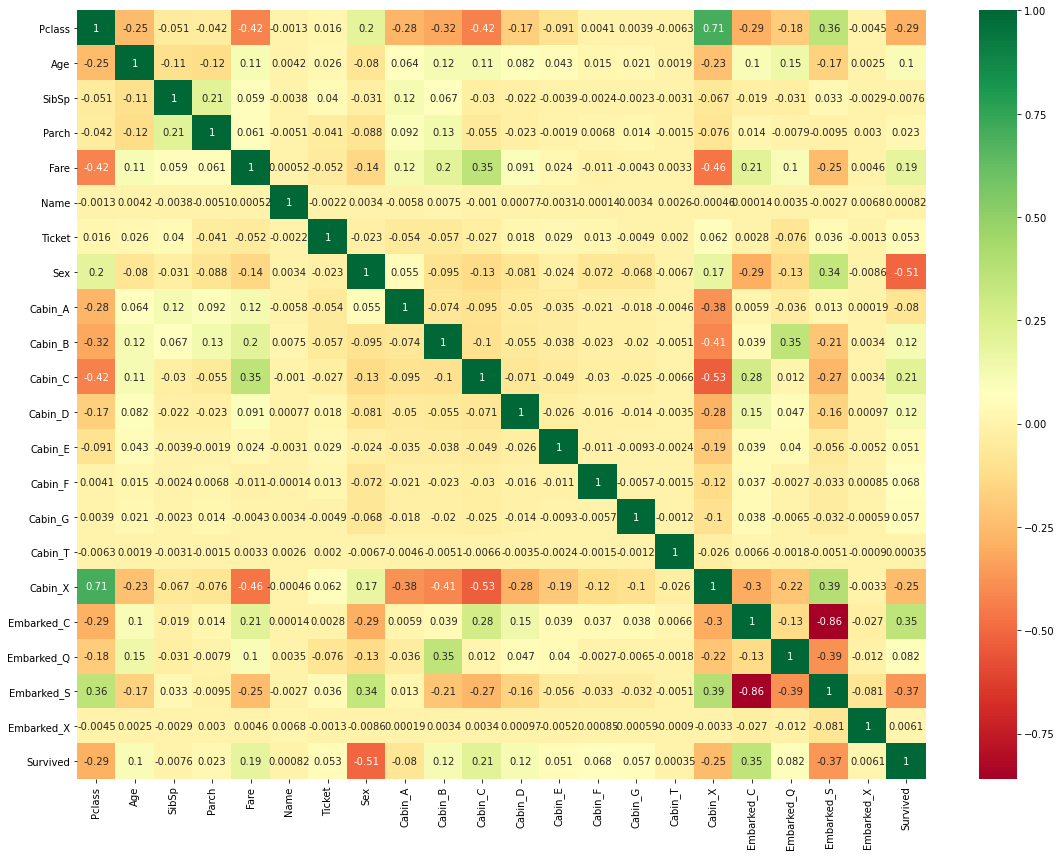

In [43]:
plt.subplots(figsize=(16,12))
sns.heatmap(data.corr(), annot=True, cmap="RdYlGn")
plt.tight_layout()
plt.show()

# Logistic Regression Model

In [44]:
clf = LogisticRegression(penalty='l2', solver = 'sag', random_state=0) # 답을 찾는 방법.. 확률적 경사하강법 
clf.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='sag')

In [45]:
predictions = clf.predict(x_test)

In [46]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.57      1.00      0.73     57226
           1       0.75      0.00      0.00     42774

    accuracy                           0.57    100000
   macro avg       0.66      0.50      0.36    100000
weighted avg       0.65      0.57      0.42    100000



In [47]:
accuracy_score(y_test, predictions)  # 이걸로 안돼는뎅 ㅎㅎ

0.57244

In [48]:
probabilities = clf.predict_proba(x_test)[:, 1]
probabilities.shape

(100000,)

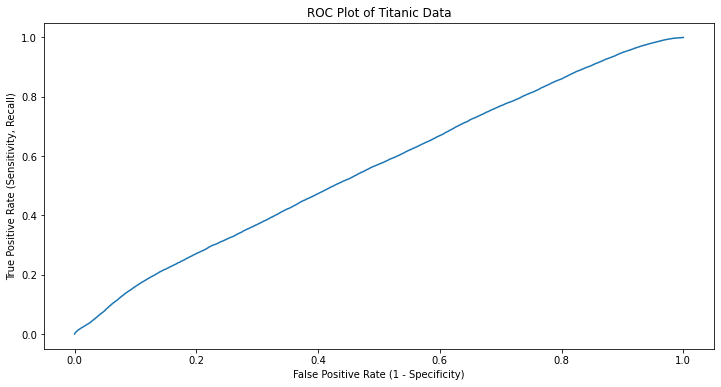

In [49]:
fpr, tpr, thresholds = roc_curve(y_test, probabilities)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(fpr, tpr)
ax.set_xlabel("False Positive Rate (1 - Specificity)")
ax.set_ylabel("True Positive Rate (Sensitivity, Recall)")
ax.set_title("ROC Plot of Titanic Data");

In [50]:
fpr, tpr, thresholds 

(array([0.00000000e+00, 1.74745745e-05, 1.74745745e-05, ...,
        9.99947576e-01, 9.99947576e-01, 1.00000000e+00]),
 array([0.00000000e+00, 0.00000000e+00, 9.35147520e-05, ...,
        9.99976621e-01, 1.00000000e+00, 1.00000000e+00]),
 array([1.50787036, 0.50787036, 0.5062203 , ..., 0.39533811, 0.39531221,
        0.39508553]))

In [54]:
data.shape

(200000, 22)

In [55]:
X_train.shape, y_train.shape,x_test.shape,y_test.shape

((180000, 21), (180000,), (100000, 21), (100000,))

In [56]:
data.head(1)

,Pclass,Age,SibSp,Parch,Fare,Name,Ticket,Sex,Cabin_A,Cabin_B,...,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,Embarked_C,Embarked_Q,Embarked_S,Embarked_X,Survived
0,-1.321331,0.356029,1.857618,-0.478448,-0.241428,14195,49,1,0,0,...,0,0,0,0,0,0,0,1,0,1


# New Split....

In [57]:
X= data.drop('Survived', axis=1)
y= data['Survived']

In [58]:
X.head(1)

,Pclass,Age,SibSp,Parch,Fare,Name,Ticket,Sex,Cabin_A,Cabin_B,...,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,Embarked_C,Embarked_Q,Embarked_S,Embarked_X
0,-1.321331,0.356029,1.857618,-0.478448,-0.241428,14195,49,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [60]:
y.head(5)

0    1
1    0
2    0
3    0
4    1
Name: Survived, dtype: int64

In [91]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

# Decision Tree Model

In [92]:
clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)

In [95]:
# fit the model
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=0)

In [96]:
y_pred_gini = clf_gini.predict(X_test)

In [97]:
print('Model accuracy score with criterion gini index: {0:0.4f}'. format(accuracy_score(y_test, y_pred_gini)))

Model accuracy score with criterion gini index: 0.7656


In [98]:
y_pred_train_gini = clf_gini.predict(X_train)
y_pred_train_gini

array([1, 0, 0, ..., 1, 0, 1])

In [99]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train_gini)))

Training-set accuracy score: 0.7632


In [100]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(clf_gini.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf_gini.score(X_test, y_test)))

Training set score: 0.7632
Test set score: 0.7656


[Text(334.8, 380.52, 'X[7] <= 0.5\ngini = 0.49\nsamples = 160000\nvalue = [91514, 68486]'),
 Text(167.4, 271.8, 'X[17] <= 0.5\ngini = 0.411\nsamples = 70203\nvalue = [20279, 49924]'),
 Text(83.7, 163.07999999999998, 'X[0] <= 0.469\ngini = 0.464\nsamples = 44832\nvalue = [16406, 28426]'),
 Text(41.85, 54.360000000000014, 'gini = 0.424\nsamples = 29271\nvalue = [8929, 20342]'),
 Text(125.55000000000001, 54.360000000000014, 'gini = 0.499\nsamples = 15561\nvalue = [7477, 8084]'),
 Text(251.10000000000002, 163.07999999999998, 'X[8] <= 0.5\ngini = 0.259\nsamples = 25371\nvalue = [3873, 21498]'),
 Text(209.25, 54.360000000000014, 'gini = 0.239\nsamples = 24388\nvalue = [3377, 21011]'),
 Text(292.95, 54.360000000000014, 'gini = 0.5\nsamples = 983\nvalue = [496, 487]'),
 Text(502.20000000000005, 271.8, 'X[19] <= 0.5\ngini = 0.328\nsamples = 89797\nvalue = [71235, 18562]'),
 Text(418.5, 163.07999999999998, 'X[0] <= 0.469\ngini = 0.499\nsamples = 12952\nvalue = [6702, 6250]'),
 Text(376.650000000

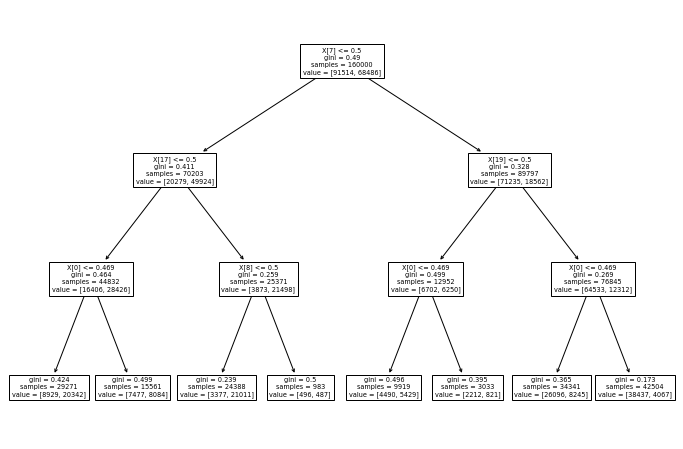

In [101]:
plt.figure(figsize=(12,8))

from sklearn import tree

tree.plot_tree(clf_gini.fit(X_train, y_train)) 


In [72]:
import graphviz 

In [74]:
# dot_data = tree.export_graphviz(clf_gini, out_file=None, 
#                               feature_names=X_train.columns,  
#                               class_names=y_train,  
#                               filled=True, rounded=True,  
#                               special_characters=True)

# graph = graphviz.Source(dot_data) 

# graph 

In [102]:
# instantiate the DecisionTreeClassifier model with criterion entropy

clf_en = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)


# fit the model
clf_en.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [103]:
y_pred_en = clf_en.predict(X_test)

In [104]:
print('Model accuracy score with criterion entropy: {0:0.4f}'. format(accuracy_score(y_test, y_pred_en)))

Model accuracy score with criterion entropy: 0.7656


In [105]:
y_pred_train_en = clf_en.predict(X_train)

y_pred_train_en

array([1, 0, 0, ..., 1, 0, 1])

In [106]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train_en)))

Training-set accuracy score: 0.7632


In [107]:

print('Training set score: {:.4f}'.format(clf_en.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf_en.score(X_test, y_test)))

Training set score: 0.7632
Test set score: 0.7656


[Text(334.8, 380.52, 'X[7] <= 0.5\nentropy = 0.985\nsamples = 160000\nvalue = [91514, 68486]'),
 Text(167.4, 271.8, 'X[17] <= 0.5\nentropy = 0.867\nsamples = 70203\nvalue = [20279, 49924]'),
 Text(83.7, 163.07999999999998, 'X[0] <= 0.469\nentropy = 0.948\nsamples = 44832\nvalue = [16406, 28426]'),
 Text(41.85, 54.360000000000014, 'entropy = 0.887\nsamples = 29271\nvalue = [8929, 20342]'),
 Text(125.55000000000001, 54.360000000000014, 'entropy = 0.999\nsamples = 15561\nvalue = [7477, 8084]'),
 Text(251.10000000000002, 163.07999999999998, 'X[8] <= 0.5\nentropy = 0.616\nsamples = 25371\nvalue = [3873, 21498]'),
 Text(209.25, 54.360000000000014, 'entropy = 0.58\nsamples = 24388\nvalue = [3377, 21011]'),
 Text(292.95, 54.360000000000014, 'entropy = 1.0\nsamples = 983\nvalue = [496, 487]'),
 Text(502.20000000000005, 271.8, 'X[19] <= 0.5\nentropy = 0.735\nsamples = 89797\nvalue = [71235, 18562]'),
 Text(418.5, 163.07999999999998, 'X[0] <= 0.469\nentropy = 0.999\nsamples = 12952\nvalue = [6702

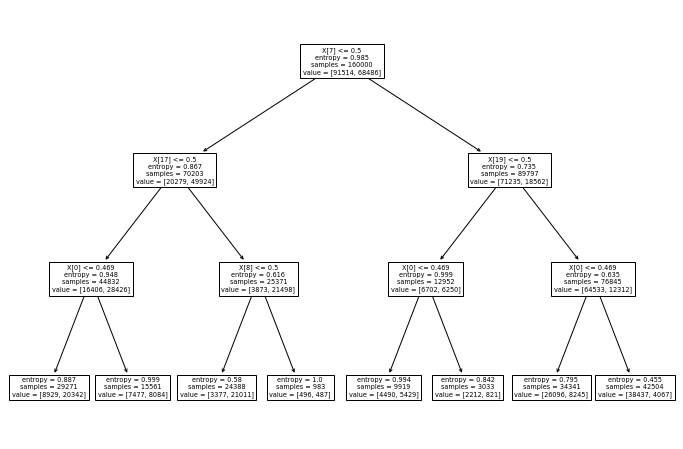

In [108]:
plt.figure(figsize=(12,8))

from sklearn import tree

tree.plot_tree(clf_en.fit(X_train, y_train)) 

In [83]:
# import graphviz 
# dot_data = tree.export_graphviz(clf_en, out_file=None, 
#                               feature_names=X_train.columns,  
#                               class_names=y_train,  
#                               filled=True, rounded=True,  
#                               special_characters=True)

# graph = graphviz.Source(dot_data) 

# graph 

In [109]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_en)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[16909  6029]
 [ 3348 13714]]


In [110]:
print(classification_report(y_test, y_pred_en))

              precision    recall  f1-score   support

           0       0.83      0.74      0.78     22938
           1       0.69      0.80      0.75     17062

    accuracy                           0.77     40000
   macro avg       0.76      0.77      0.76     40000
weighted avg       0.77      0.77      0.77     40000



In [111]:
from sklearn.ensemble import RandomForestClassifier

# instantiate the classifier 
rfc = RandomForestClassifier(random_state=0)

# fit the model
rfc.fit(X_train, y_train)

# Predict the Test set results
y_pred = rfc.predict(X_test)

# Check accuracy score 
print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with 10 decision-trees : 0.9528


In [112]:
# instantiate the classifier with n_estimators = 100
rfc_100 = RandomForestClassifier(n_estimators=100, random_state=0)

# fit the model to the training set
rfc_100.fit(X_train, y_train)

# Predict on the test set results
y_pred_100 = rfc_100.predict(X_test)

# Check accuracy score 
print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred_100)))

Model accuracy score with 100 decision-trees : 0.9528


In [113]:
# create the classifier with n_estimators = 100
clf = RandomForestClassifier(n_estimators=100, random_state=0)

# fit the model to the training set
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [114]:
# view the feature scores

feature_scores = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

Fare          0.227923
Name          0.206767
Sex           0.189749
Age           0.140170
Embarked_S    0.040864
Pclass        0.036710
Ticket        0.033194
Embarked_C    0.032446
Parch         0.021594
SibSp         0.021051
Cabin_A       0.013015
Cabin_X       0.012871
Cabin_C       0.009018
Cabin_B       0.004478
Embarked_Q    0.003174
Cabin_D       0.002932
Cabin_E       0.001501
Cabin_F       0.001333
Cabin_G       0.000682
Embarked_X    0.000379
Cabin_T       0.000150
dtype: float64

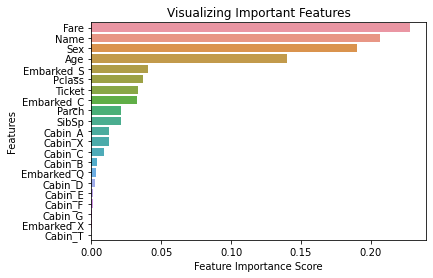

In [115]:
# Creating a seaborn bar plot
sns.barplot(x=feature_scores, y=feature_scores.index)

# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')

# Add title to the graph
plt.title("Visualizing Important Features")

# Visualize the graph
plt.show()

In [51]:
N_ESTIMATORS = 1000
N_SPLITS = 10
SEED = 2021
EARLY_STOPPING_ROUNDS = 100
VERBOSE = 100

In [52]:
# https://www.kaggle.com/hiro5299834/tps-apr-2021-pseudo-labeling-voting-ensemble 

# Tuning the DecisionTreeClassifier by the GridSearchCV
parameters = {
    'max_depth': np.arange(2, 5, dtype=int),
    'min_samples_leaf':  np.arange(2, 5, dtype=int)
}

classifier = DecisionTreeClassifier(random_state=2021)

model = GridSearchCV(
    estimator=classifier,
    param_grid=parameters,
    scoring='accuracy',
    cv=10,
    n_jobs=-1)
model.fit(X_train, y_train)

best_parameters = model.best_params_
print(best_parameters)

# {'max_depth': 4, 'min_samples_leaf': 2}

{'max_depth': 4, 'min_samples_leaf': 2}


In [53]:
SEED = 2021
dtm_oof = np.zeros(train.shape[0])
dtm_preds = np.zeros(test.shape[0])
feature_importances = pd.DataFrame()

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

for fold, (train_idx, valid_idx) in enumerate(skf.split(data,data['Survived'])):
    print(f"===== FOLD {fold} =====")
    oof_idx = np.array([idx for idx in valid_idx if idx < train.shape[0]])
    preds_idx = np.array([idx for idx in valid_idx if idx >= train.shape[0]])

    X_train, y_train = data.iloc[train_idx].drop('Survived', axis=1), data.iloc[train_idx]['Survived']
    X_valid, y_valid = data.iloc[oof_idx].drop('Survived', axis=1), data.iloc[oof_idx]['Survived']
    X_test = data.iloc[preds_idx].drop('Survived', axis=1)
    
    model = DecisionTreeClassifier(
        max_depth=best_parameters['max_depth'],
        min_samples_leaf=best_parameters['min_samples_leaf'],
        random_state=SEED
    )
    model.fit(X_train, y_train)
    
    dtm_oof[oof_idx] = model.predict(X_valid)
    dtm_preds[preds_idx-train.shape[0]] = model.predict(x_test)
    
    acc_score = accuracy_score(y_valid, np.where(dtm_oof[oof_idx]>0.5, 1, 0))
    print(f"===== ACCURACY SCORE {acc_score:.6f} =====\n")
    
acc_score = accuracy_score(data[:train.shape[0]]['Survived'], np.where(dtm_oof>0.5, 1, 0))
print(f"===== ACCURACY SCORE {acc_score:.6f} =====")

===== FOLD 0 =====


ValueError: shape mismatch: value array of shape (100000,) could not be broadcast to indexing result of shape (9885,)

In [ ]:
# plot tree
dot_data = export_graphviz(
    model,
    out_file=None,
    feature_names=X_train.columns,
    class_names=['0', '1'],
    filled=True,
    rounded=False,
    special_characters=True,
    precision=3
)
graph = graphviz.Source(dot_data)
graph 

In [ ]:
LGB Boost
Random Forest
